<a href="https://colab.research.google.com/github/nedokormysh/GB_CV_med/blob/Lesson_2_classification_pneumothorax/GB_CV_med_hw_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание.**

- Прочитать статью ""An Improved VGG16 Model for Pneumonia Image Classification"" by Zhi-Peng Jiang et al., 2021.

- Реализовать модель диагностики пневмоторакса на основе IVGG13 (см. статью)

- Выполнить тюнинг гиперпараметров модели и улучшить метрики accuracy, precision, recall по сравнению с исходной моделью, представленной в уроке.

- Провести сравнительный анализ ROC-кривых полученных моделей. Выбрать оптимальный threshold.

In [ ]:
!pip install pydicom -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.0 MB/s eta 0:00:00


In [ ]:
import zipfile
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm.notebook import tqdm

## Загрузка данных из Kaggle в Colab

In [ ]:
! mkdir ~/.kaggle
! echo '{"username":"prubin","key":"bc63154694525c4eac572416b03d0f0a"}' > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json  # устанавливаем разрешения
! pip install kaggle -q

In [ ]:
! kaggle datasets download anisayari/siimacrpneumothoraxsegmentationzip-dataset

Dataset URL: https://www.kaggle.com/datasets/anisayari/siimacrpneumothoraxsegmentationzip-dataset
License(s): unknown
100% 14.7G/14.7G [02:55<00:00, 176MB/s]
100% 14.7G/14.7G [02:55<00:00, 90.2MB/s]


In [ ]:
%time
data_r = zipfile.ZipFile('/content/siimacrpneumothoraxsegmentationzip-dataset.zip', 'r')
data_r.extractall('/content/kaggle/')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


## Preprocessing

In [ ]:
labels = pd.read_csv('/content/kaggle/input/train/train-rle.csv')
labels.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [ ]:
print(f"Всего записей: {labels['ImageId'].count()}, из них уникальных {labels['ImageId'].value_counts().shape[0]}")

Всего записей: 11582, из них уникальных 10675


Мы используем некий новый датасет, который оказался доступен.

! kaggle datasets download anisayari/siimacrpneumothoraxsegmentationzip-dataset

Датасет с занятия имел и другую структуру папок и другое (большее) количество объектов.

In [ ]:
import os

folder_path = '/content/kaggle/input/input/train/dicom_files'

files = os.listdir(folder_path)

# Считаем количество файлов
num_files = len(files)

print(f'Количество файлов в папке: {num_files}')

Количество файлов в папке: 10712


У нас не совпадает количество изображений и описание к ним.

In [ ]:
labels = labels.drop_duplicates('ImageId')
labels.shape

(10675, 2)

In [ ]:
labels.columns = ['ImageId', 'Target']

Заменим лейблы -1 на 0, иные значения на 1.

In [ ]:
# Преобразуем строки в списки чисел
labels['Target'] = labels['Target'].str.split()

# Преобразуем списки в числовые значения
labels['Target'] = labels['Target'].apply(lambda x: [int(i) for i in x])

def transform_target(x):
    if x != [-1]:
        return 1
    else:
        return 0

labels['Target'] = labels['Target'].apply(transform_target)
labels['Target'] = labels.Target.astype('int64')

<ipython-input-11-ead47739715f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['Target'] = labels['Target'].str.split()


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10675 entries, 0 to 11581
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  10675 non-null  object
 1   Target   10675 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.2+ KB


In [ ]:
labels['Target'].value_counts()

Target
0    8296
1    2379
Name: count, dtype: int64

In [ ]:
ROOT_PATH = Path("/content/kaggle/input/train/dicom_files")
SAVE_PATH = Path("/content/Processed/train_or_val/")

In [ ]:
# Получаем список файлов в директории и ее поддиректориях
all_train_dcm = glob(f"{ROOT_PATH}/**/*.*", recursive=True)
all_train_dcm[0]

'/content/kaggle/input/train/dicom_files/1.2.276.0.7230010.3.1.4.8323329.5310.1517875187.546496.dcm'

Отобразим изображения

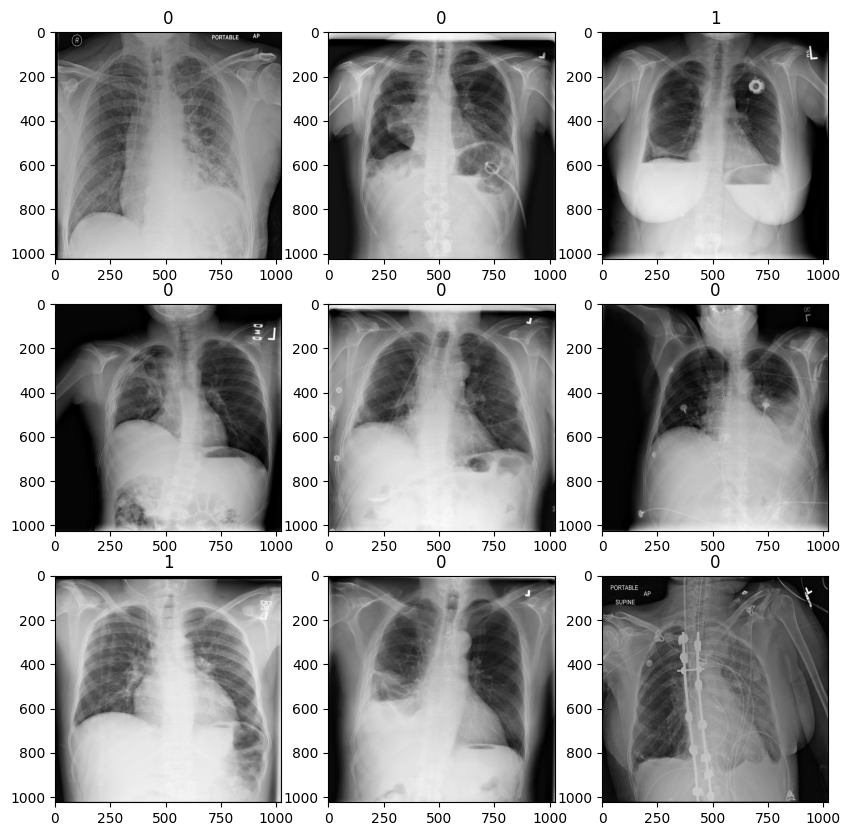

In [ ]:
import random

fig, axis = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        # Генерируем случайный индекс
        c = random.randint(0, len(all_train_dcm) - 1)

        dcm = pydicom.read_file(all_train_dcm[c]).pixel_array
        label = labels['Target'].iloc[c]

        axis[i][j].imshow(dcm, cmap='gray')
        axis[i][j].set_title(label)

In [ ]:
# fig, axis = plt.subplots(3, 3, figsize=(10, 10))

# c = 0

# for i in range(3):
#     for j in range(3):
#         dcm = pydicom.read_file(all_train_dcm[c]).pixel_array
#         label = labels['Target'].iloc[c]

#         axis[i][j].imshow(dcm, cmap='gray')
#         axis[i][j].set_title(label)
#         c+=1

Разрешение изображения: ширина 1024 пикселей и высота 1024 пикселей, один канал
Максимальное значение пикселя 255.0 минимальное значение 0.0
Среднее пикселей 109.40 стандартное отклонение 55.58


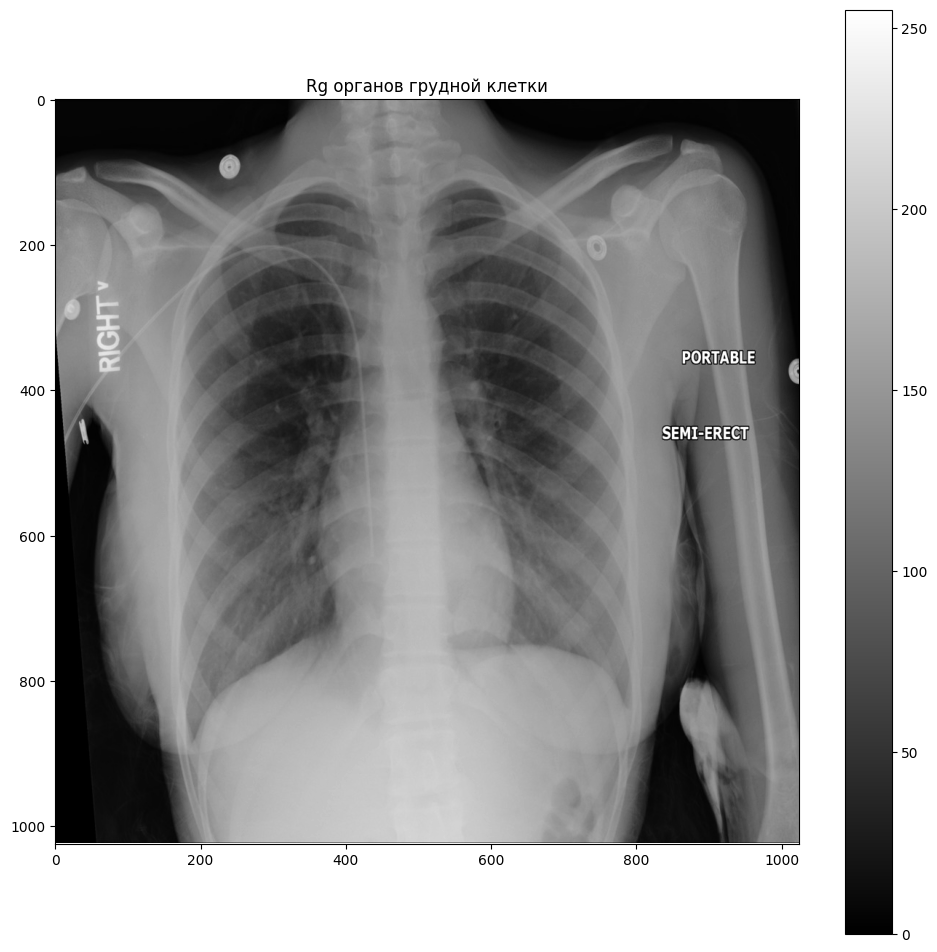

In [ ]:
plt.figure(figsize=(12, 12))
raw_image = pydicom.read_file(all_train_dcm[1]).pixel_array
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Rg органов грудной клетки')
print(f"Разрешение изображения: ширина {raw_image.shape[0]} пикселей и высота {raw_image.shape[1]} пикселей, один канал")
print(f"Максимальное значение пикселя {raw_image.max():.1f} минимальное значение {raw_image.min():.1f}")
print(f"Среднее пикселей {raw_image.mean():.2f} стандартное отклонение {raw_image.std():.2f}")

Посмотрим распределение значений пикселей отдельного изображения.

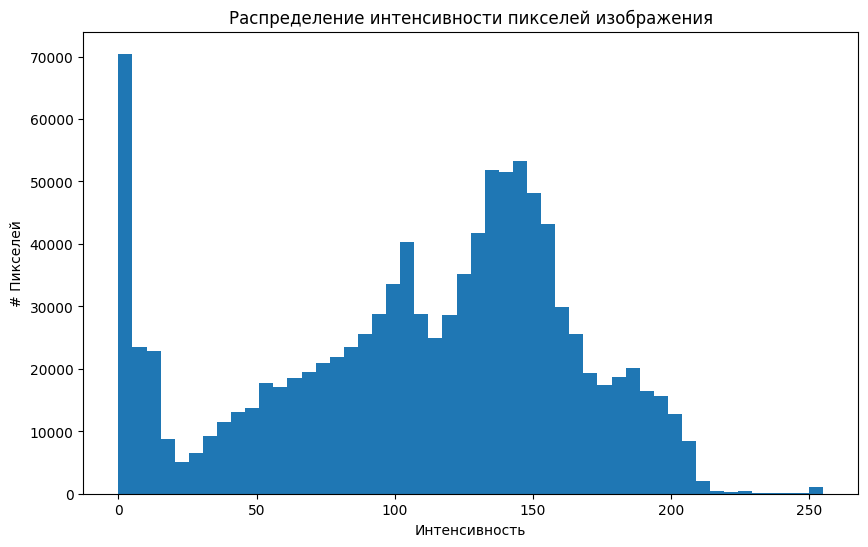

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(raw_image.ravel(), bins=50)
plt.title('Распределение интенсивности пикселей изображения')
plt.xlabel('Интенсивность')
plt.ylabel('# Пикселей')
plt.show()

## Подготовка датасета

In [ ]:
!mkdir /content/Processed/

Для IVGG13 размер входных изображений 128x128

In [ ]:
n_train = 10675 * 4/5
size = 128

In [ ]:
# Определим две переменные для хранения суммы и суммы квадратов
sums, sums_squared = 0, 0

for c, image_id in enumerate(tqdm(labels.ImageId)):
    dcm_path = glob('/content/kaggle/input/train/dicom_files/' + image_id + '.dcm')[0]

    dcm = pydicom.read_file(str(dcm_path)).pixel_array / 255

    dcm_array = cv2.resize(dcm, (size, size)).astype(np.float16)

    # label = labels.Target.iloc[c]
    label = labels.loc[labels.ImageId == image_id, 'Target'].iloc[0]
    train_or_val = "train" if c < n_train else "val"

    current_save_path = SAVE_PATH/str(train_or_val)/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/image_id, dcm_array)

    # Определим количество пикселей в изображении, т.е. 128*128
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]

    # Используем только тренировочные данные для расчета статистик, это необходимо, чтобы валидационные
    # данные не имели влияния на тренировочные
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

  0%|          | 0/10675 [00:00<?, ?it/s]

In [ ]:
mean = sums / n_train
std = np.sqrt((sums_squared / n_train) - mean**2)
print(f"Среднее: {mean}, Ст. отклонение: {std}")

Среднее: 0.49045834686493706, Ст. отклонение: 0.24708441921673988


In [ ]:
mean = 0.49045834686493706
std = 0.24708441921673988

### Аугментация

In [ ]:
!pip install torchmetrics -q
!pip install pytorch_lightning -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 12.5 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
# Определим функцию, принимающую в качестве аргумента путь к numpy файлу
# и конвертирующую значения в тип данных float
def load_file(path):
    return np.load(path).astype(np.float32)

In [ ]:
train_transforms = transforms.Compose([
                                    # конвертирует numpy array в тензор
                                    transforms.ToTensor(),
                                    # принимает в качестве аргументов наши, уже вычисленные mean and std
                                    transforms.Normalize(mean, std),
                                    transforms.RandomAffine(
                                        degrees=(-5, 5),
                                        translate=(0, 0.05),
                                        scale=(0.9, 1.1)),
                                    # transforms.RandomResizedCrop((size, size), scale=(0.15, 1))

])

val_transforms = transforms.Compose([
                                    # конвертирует numpy array в тензор
                                    transforms.ToTensor(),
                                    # принимает в качестве аргументов наши, уже вычисленные mean and std
                                    transforms.Normalize(mean, std),
                                    # transforms.Resize((size, size))
                                    # transforms.RandomResizedCrop((128, 128), scale=(0.15, 1))
])

In [ ]:
train_dataset = torchvision.datasets.DatasetFolder(
    f'{SAVE_PATH}/train',
    loader=load_file,
    extensions="npy",
    transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    f'{SAVE_PATH}/val',
    loader=load_file,
    extensions='npy',
    transform=val_transforms)

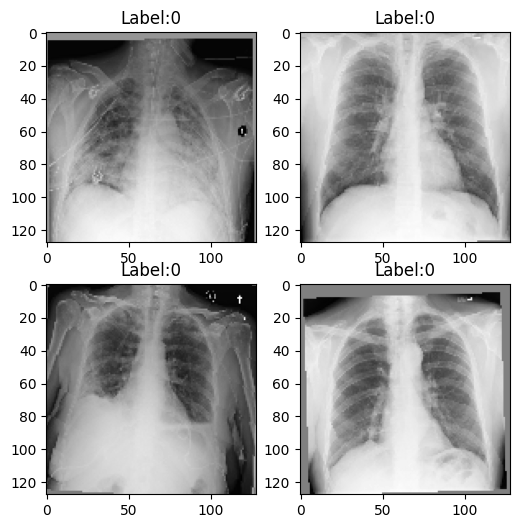

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(6, 6))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, n_train)
        x_ray, label = train_dataset[random_index]
        # Класс DatasetFolder автоматически добавляет количество каналов, поэтому используем индекс x_ray[0]
        axis[i][j].imshow(x_ray[0], cmap="gray")
        axis[i][j].set_title(f"Label:{label}")

Разрешение изображения: ширина 128 пикселей и высота 128 пикселей, один канал
Максимальное значение пикселя 1.9 минимальное значение -1.9
Среднее пикселей 0.67 стандартное отклонение 0.82


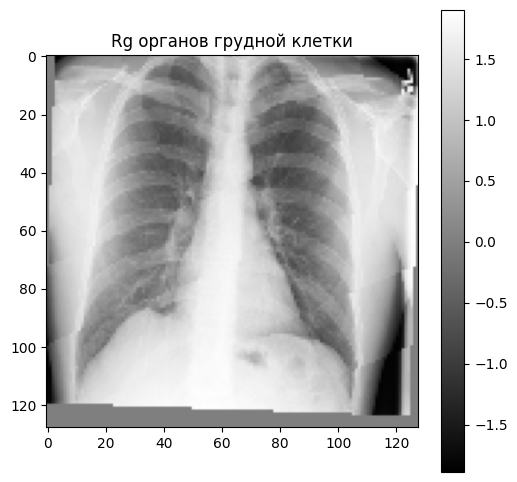

In [ ]:
plt.figure(figsize=(6, 6))
sample_image, l = train_dataset[0]
plt.imshow(sample_image[0], cmap='gray')
plt.colorbar()
plt.title('Rg органов грудной клетки')
print(f"Разрешение изображения: ширина {sample_image.shape[1]} пикселей и высота {sample_image.shape[2]} пикселей, один канал")
print(f"Максимальное значение пикселя {sample_image.max():.1f} минимальное значение {sample_image.min():.1f}")
print(f"Среднее пикселей {sample_image.mean():.2f} стандартное отклонение {sample_image.std():.2f}")

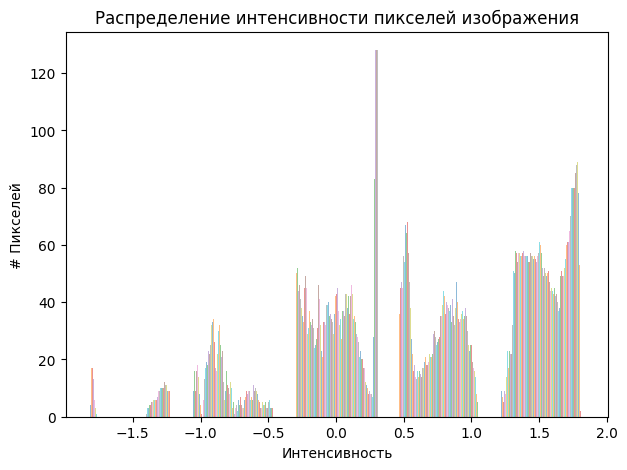

In [ ]:
plt.figure(figsize=(7,5))
#plt.hist(raw_image.ravel(), bins=50, alpha=0.5)
plt.hist(sample_image[0], bins=5, alpha=0.5)
plt.title('Распределение интенсивности пикселей изображения')
plt.xlabel('Интенсивность')
plt.ylabel('# Пикселей')
plt.show()

In [ ]:
batch_size = 32
num_workers = 2

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)

print(f"Всего {len(train_dataset)} тренировочных изображений и {len(val_dataset)} валидационных.")

Всего 8540 тренировочных изображений и 2135 валидационных.


## Model IVGG13

In [ ]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([6169, 2371]))

In [ ]:
w = 6169/2371
w

2.6018557570645298

In [ ]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Посмотрим на vgg16()
# Посмотрим архитектуру модели
torchvision.models.vgg16()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Авторами статьи предложена следующая схема IVGG13 как модификация VGG16.

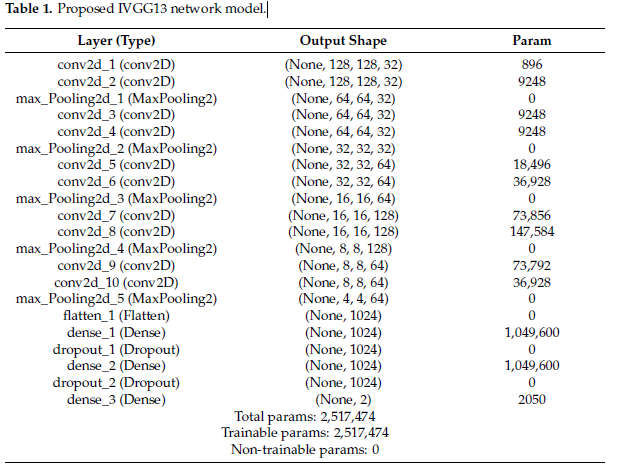

Напишем класс IVGG13

In [ ]:
class IVGG13(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.conv_blocks = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.conv_blocks(x)
        x = self.fc(x)
        return x

In [ ]:
model = IVGG13()
model

IVGG13(
  (conv_blocks): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): Re

In [ ]:
# Получаем количество параметров
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total params: {total_params}')

# Получить количество trainable (обучаемых) параметров
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Trainable params: {trainable_params}')

Total params: 2515873
Trainable params: 2515873


Т.к. у нас на входе 1 канал, то количество параметров немного отличается от количества, определённого в статье.
Кроме того, авторы статьи на выходе получают 2 класса. Мы же будем возвращать 1 значение - вероятность отнесения к первому классу.

In [ ]:
class PneumothoraxModelIGG13(pl.LightningModule):
    def __init__(self, model,
                 weight=3,
                 lr=1e-4):
        super().__init__()
        self.model = model
        self.lr = lr
        self.loss_fn = torch.nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor([weight])
            )
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.train_f1 = torchmetrics.F1Score(task="binary", num_classes=1, average='binary')
        self.val_f1 = torchmetrics.F1Score(task="binary", num_classes=1, average='binary')
        self.train_losses = []
        self.val_losses = []
        self.val_accs = []
        self.val_f1s = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc(torch.sigmoid(pred), label.long()))
        self.log('train_f1', self.train_f1(torch.sigmoid(pred), label.long()))
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.trainer.callback_metrics['train_loss'])
        self.log('train_epoch_acc', self.train_acc.compute())
        self.log('train_epoch_f1', self.train_f1.compute())
        self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        self.log('val_loss', loss)
        self.log('val_acc', self.val_acc(torch.sigmoid(pred), label.long()))
        self.log('val_f1', self.val_f1(torch.sigmoid(pred), label.long()))
        return loss

    def on_validation_epoch_end(self):
        self.val_losses.append(self.trainer.callback_metrics['val_loss'])
        self.val_accs.append(self.val_acc.compute())
        self.log('val_epoch_acc', self.val_acc.compute())
        self.val_acc.reset()
        self.val_f1s.append(self.val_f1.compute())
        self.log('val_epoch_f1', self.val_f1.compute())
        self.val_f1.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)


    # def load_from_checkpoint(checkpoint_path, *args, **kwargs):
    #     model = IVGG13(*args, **kwargs)  # Создаем экземпляр IVGG13 с переданными аргументами
    #     return super(PneumothoraxModelIGG13, PneumothoraxModelIGG13).load_from_checkpoint(checkpoint_path, model=model)
    @staticmethod
    def load_from_checkpoint(checkpoint_path, model_class, *args, **kwargs):
        model = model_class(*args, **kwargs)  # Создаем экземпляр модели с переданными аргументами
        return super(PneumothoraxModelIGG13, PneumothoraxModelIGG13).load_from_checkpoint(checkpoint_path, model=model)


In [ ]:
model = IVGG13()
pneumothorax_model = PneumothoraxModelIGG13(model, weight=w)

In [ ]:
# создаем чекпоинт, основанный на валидационной accuracy
# автоматически сохраняет чекпоинты в течение тренинга
checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    save_top_k=10,
    mode='max')

In [ ]:
trainer = pl.Trainer(max_epochs=30,
                     logger=TensorBoardLogger(save_dir="./logs"),
                     log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     )
trainer.fit(pneumothorax_model, train_loader, val_loader)

train_losses = pneumothorax_model.train_losses
val_losses = pneumothorax_model.val_losses
val_accs = pneumothorax_model.val_accs
val_f1s = pneumothorax_model.val_f1s

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | IVGG13            | 2.5 M  | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
4 | train_f1  | BinaryF1Score     | 0      | train
5 | val_f1    | BinaryF1Score     | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.063    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


### Результаты

In [ ]:
# # Загрузка TensorBoard
# %load_ext tensorboard

In [ ]:
#  # Путь к логам
#  logdir = 'logs/'

In [ ]:
# %tensorboard --logdir logs

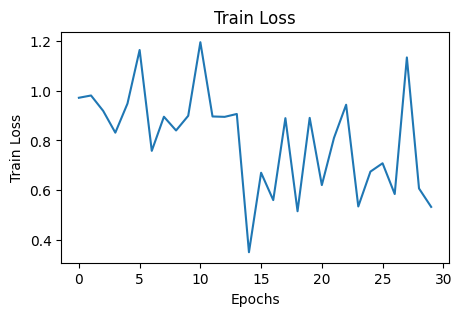

In [ ]:
tr_losses = torch.stack(train_losses).cpu().numpy()

plt.figure(figsize=(5, 3))
plt.plot(tr_losses)
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.title("Train Loss")
plt.show()

In [ ]:
vl_losses = torch.stack(val_losses).cpu().numpy()
vl_accs = torch.stack(val_accs).cpu().numpy()

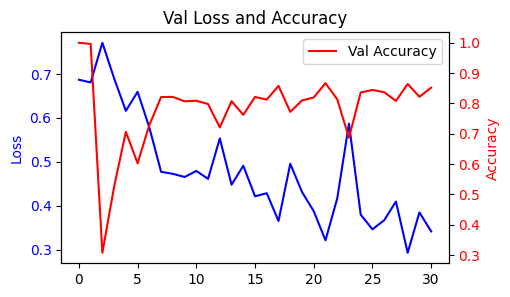

In [ ]:
plt.figure(figsize=(5, 3))

# Отображение валидационных потерь на левой оси y
plt.plot(vl_losses, label='Val Loss', color='blue')
plt.ylabel("Loss", color='blue')
plt.tick_params(axis='y', labelcolor='blue')

# Добавление второй оси y для отображения точности
ax2 = plt.twinx()
plt.plot(vl_accs, label='Val Accuracy', color='red')
plt.ylabel("Accuracy", color='red')
plt.tick_params(axis='y', labelcolor='red')

plt.xlabel("Epochs")
plt.title("Val Loss and Accuracy")
plt.legend()
plt.show()

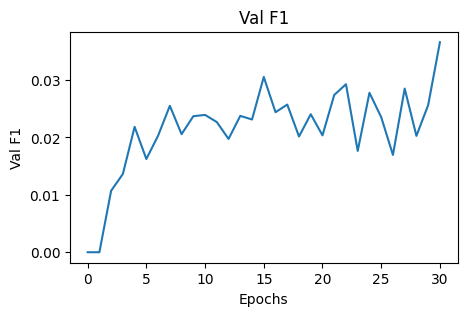

In [ ]:
vl_f1s = torch.stack(val_f1s).cpu().numpy()

plt.figure(figsize=(5, 3))
plt.plot(vl_f1s)
plt.xlabel("Epochs")
plt.ylabel("Val F1")
plt.title("Val F1")
plt.show()

In [ ]:
# Проверяем используется ли gpu, и если да, то используем его
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Загрузка чекпойнта.
model = PneumothoraxModelIGG13.load_from_checkpoint("/content/logs/lightning_logs/version_0/checkpoints/epoch=29-step=8010.ckpt", model_class=IVGG13)
model.eval()
model.to(device)

PneumothoraxModelIGG13(
  (model): IVGG13(
    (conv_blocks): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (15): Conv2d(64,

In [ ]:
# Теперь вычислим метрики на всем валидационном датасете
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())

        preds.append(pred)
        labels.append(label)

# Конвертируем списки в тензор, чтобы использовать torch.metrics
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2135 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# Создаем пустой DataFrame
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score'])

# Вычисляем метрики для вашей модели
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)
f1score = torchmetrics.F1Score(task="binary")(preds, labels)
roc_auc = roc_auc_score(labels, preds)

# Преобразуем тензоры в numpy массивы и берем их значения
acc_value = acc.numpy().item()
precision_value = precision.numpy().item()
recall_value = recall.numpy().item()
f1score_value = f1score.numpy().item()

# Создаем новую строку и добавляем ее в metrics_df
new_row = pd.DataFrame({'Model': ['IVGG13'],
                        'Accuracy': [acc_value],
                        'Precision': [precision_value],
                        'Recall': [recall_value],
                        'F1 Score': [f1score_value],
                        'ROC AUC Score': [roc_auc]})

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,IVGG13,0.851991,0.01875,0.75,0.036585,0.818054


In [ ]:
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)
f1score = torchmetrics.F1Score(task="binary")(preds, labels)
cm = torchmetrics.ConfusionMatrix(#num_classes=2,
                                  task="binary")(preds, labels)
# cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.73, task="binary")(preds, labels)

print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1score}")
print(f"Confusion Matrix:\n {cm}")
# print(f"Confusion Matrix 2:\n {cm_threshed}")

Accuracy: 0.8519906401634216
Precision: 0.01875000074505806
Recall: 0.75
F1 Score: 0.03658536449074745
Confusion Matrix:
 tensor([[1813,  314],
        [   2,    6]])


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true: np.ndarray,
                          prediction: np.ndarray,
                          cmap: str = 'Blues'):
    """Визуализация ConfusionMatrix
    :param y_true: массив с настоящими значениями целевой переменной
    :param prediction: массив с прогнозируемыми значениями
    :param cmap: строка для выбора цвета отрисовки графика
    """
    cm_ovr = confusion_matrix(y_true, prediction)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_ovr)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    disp.plot(ax=ax, cmap=cmap)

    ax.title.set_text('Confusion Matrix')
    plt.sca(ax)
    plt.xticks(rotation=45)

    plt.tight_layout()

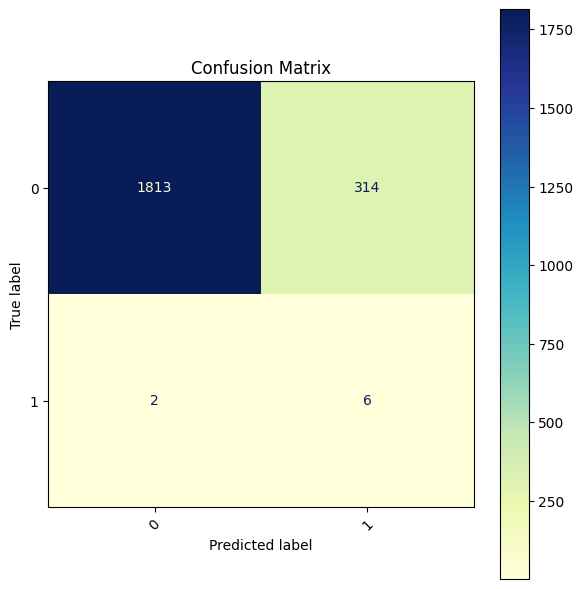

In [ ]:
# Преобразуем тензоры в numpy массивы
y_true = labels.numpy()
prediction = preds.detach().numpy()

# Преобразуем prediction в бинарные метки
prediction_binary = (prediction > 0.5).astype(int)

# Вызываем функцию plot_confusion_matrix
plot_confusion_matrix(y_true=y_true,
                      prediction=prediction_binary,
                      cmap='YlGnBu')

In [ ]:
tpr = cm[1][1] / (cm[1][1] + cm[1][0])
fpr = cm[0][1] / (cm[0][1] + cm[0][0])

print (f'True Positive Rate (threshold = 0.5): {tpr:.2f}')
print (f'False Positive Rate (threshold = 0.5): {fpr:.2f}')

True Positive Rate (threshold = 0.5): 0.75
False Positive Rate (threshold = 0.5): 0.15


In [ ]:
from torchmetrics import AUROC, ROC

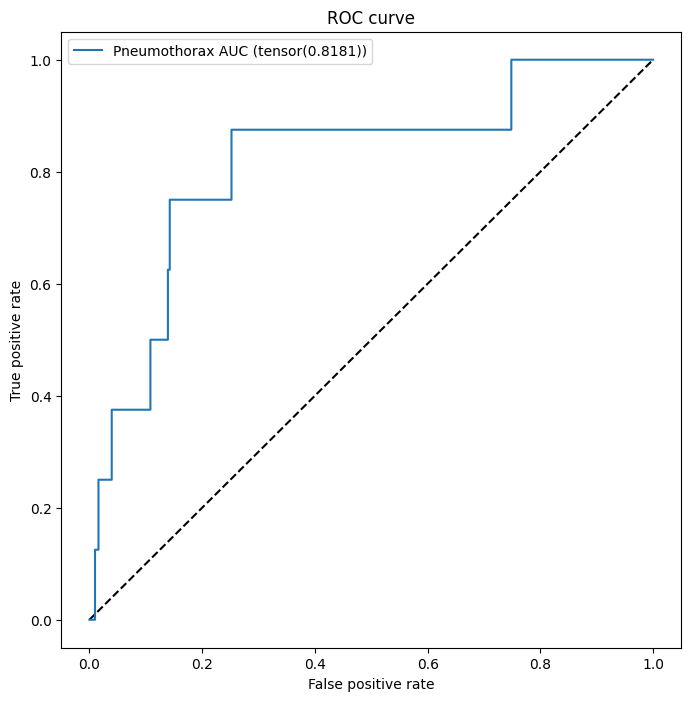

In [ ]:
auroc = AUROC(task='binary')
auc_roc = auroc(preds, labels)
roc_curve = torchmetrics.ROC(task='binary')
fpr_rf, tpr_rf, thresholds = roc_curve(preds,labels)
plt.figure(1, figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = "Pneumothorax AUC (" + str(auc_roc) + ")")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='upper left')

Найдём оптимальный порог

In [ ]:
optimal_idx = np.argmax(tpr_rf - fpr_rf)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal threshold: {optimal_threshold}')

Optimal threshold: 0.31611713767051697


In [ ]:
cm_threshed = torchmetrics.ConfusionMatrix(#num_classes=2,
                                           threshold=0.55760,
                                           task="binary")(preds, labels)
cm_threshed

tensor([[1857,  270],
        [   4,    4]])

Выведем матрицу ошибок с использованием оптимального порога

Confusion Matrix:
[[1591  536]
 [   2    6]]


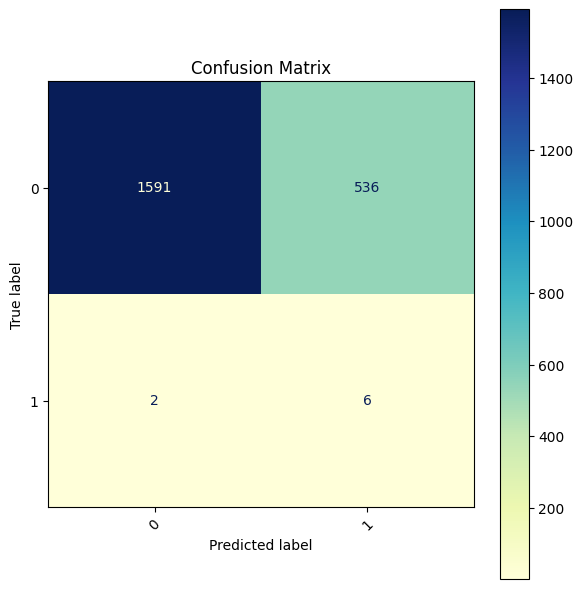

In [ ]:
# Преобразуем optimal_threshold в numpy массив
optimal_threshold = optimal_threshold.numpy()

# Преобразуем prediction в бинарные метки с использованием оптимального порога
prediction_binary = (prediction > optimal_threshold).astype(int)

# Вычисляем Confusion Matrix
cm_ovr = confusion_matrix(y_true, prediction_binary)

# Выводим Confusion Matrix
print('Confusion Matrix:')
print(cm_ovr)

# Вызываем функцию plot_confusion_matrix
plot_confusion_matrix(y_true=y_true,
                      prediction=prediction_binary,
                      cmap='YlGnBu')


Также рассмотрим матрицу ошибок для тестовых данных

  0%|          | 0/8540 [00:00<?, ?it/s]

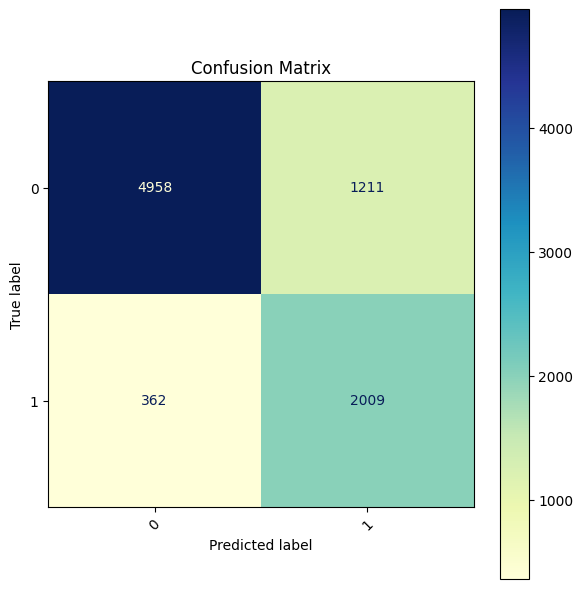

In [ ]:
# Делаем предсказания для тренировочных данных
preds_train = []
labels_train = []

with torch.no_grad():
    for data, label in tqdm(train_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())

        preds_train.append(pred)
        labels_train.append(label)

# Преобразуем тензоры в numpy массивы
y_true_train = torch.tensor(labels_train).int().numpy()
prediction_train = torch.tensor(preds_train).numpy()

# Преобразуем prediction в бинарные метки
prediction_binary_train = (prediction_train > 0.5).astype(int)

# Вызываем функцию plot_confusion_matrix
plot_confusion_matrix(y_true=y_true_train,
                      prediction=prediction_binary_train,
                      cmap='YlGnBu')

Визуализация решений классификатора

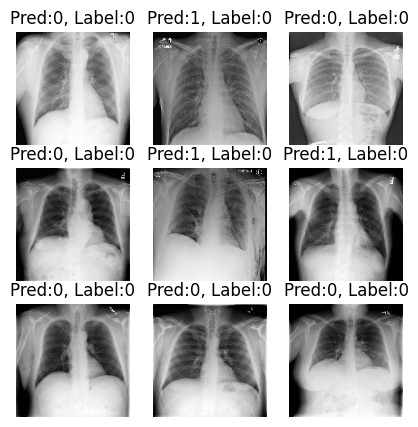

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(5, 5))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="gray")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")

In [ ]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,IVGG13,0.851991,0.01875,0.75,0.036585,0.818054


**Выводы:**
- в принципе модель уже где-то к 20-ой эпохе обучается
- результаты модели достаточно плохие
- если рассматривать матрицу ошибок на трейн выборке, мы достаточно хорошо предсказываем классы. Но достаточно много ложноположительных ошибок
- в выборке валидационной действительно мало объектов первого класса, но результаты плохие, пусть и accuracy и roc_auc показывают относительно нормальные значения
- выбор оптимального порога в данном случае не имеет особого смысла, т.к. объекты практически все прогнозируются 0. И изменения не дают сильных значимых улучшений

## Модель IVGG13 (изменённая)

Попробуем изменить класс

- Добавили residual слои: В блоках 3, 4 и 5 мы добавили residual слои, которые помогают решить проблему исчезающего градиента.
- Увеличили увеличили количество фильтров в сверточных слоях, чтобы увеличить емкость сети и позволить ей учиться более сложным функциям.
- Заменили функцию активации ReLU на LeakyReLU, которая позволяет нейронам иметь небольшой отрицательный градиент, даже если их активация равна нулю. Это помогает решить проблему "мертвых" нейронов, которая может возникнуть при использовании ReLU.
- Добавили Batch Normalization после каждого сверточного слоя, чтобы нормализовать входные данные для каждого нейрона. Это помогает улучшить обучение сети и уменьшает необходимость в тщательной настройке гиперпараметров.
- Увеличили количество нейронов в полносвязных слоях:

In [ ]:
class IVGG13_b(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.conv_blocks = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.conv_blocks(x)
        x = self.fc(x)
        return x

In [ ]:
model = IVGG13_b()
pneumothorax_model = PneumothoraxModelIGG13(model, weight=w)

In [ ]:
# создаем чекпоинт, основанный на валидационной accuracy
# автоматически сохраняет чекпоинты в течение тренинга
checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    save_top_k=10,
    mode='max')

In [ ]:
trainer = pl.Trainer(max_epochs=20,
                     logger=TensorBoardLogger(save_dir="./logs_b"),
                     log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     )
trainer.fit(pneumothorax_model, train_loader, val_loader)

train_losses = pneumothorax_model.train_losses
val_losses = pneumothorax_model.val_losses
val_accs = pneumothorax_model.val_accs
val_f1s = pneumothorax_model.val_f1s

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | IVGG13_b          | 11.7 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
4 | train_f1  | BinaryF1Score     | 0      | train
5 | val_f1    | BinaryF1Score     | 0      | train
--------------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.836    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


### Результаты

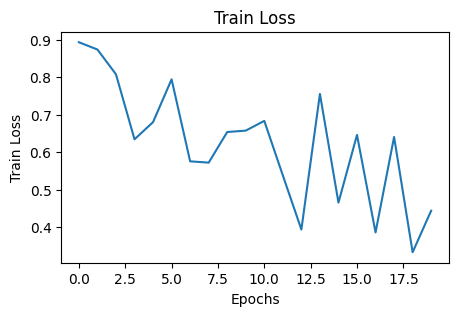

In [ ]:
tr_losses = torch.stack(train_losses).cpu().numpy()

plt.figure(figsize=(5, 3))
plt.plot(tr_losses)
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.title("Train Loss")
plt.show()

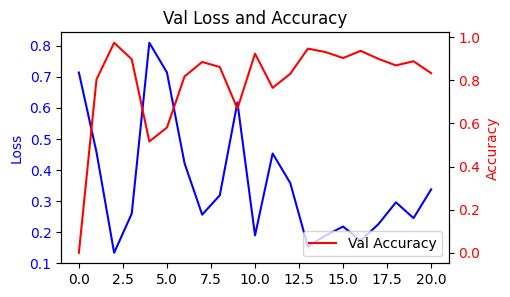

In [ ]:
vl_losses = torch.stack(val_losses).cpu().numpy()
vl_accs = torch.stack(val_accs).cpu().numpy()

plt.figure(figsize=(5, 3))

# Отображение валидационных потерь на левой оси y
plt.plot(vl_losses, label='Val Loss', color='blue')
plt.ylabel("Loss", color='blue')
plt.tick_params(axis='y', labelcolor='blue')

# Добавление второй оси y для отображения точности
ax2 = plt.twinx()
plt.plot(vl_accs, label='Val Accuracy', color='red')
plt.ylabel("Accuracy", color='red')
plt.tick_params(axis='y', labelcolor='red')

plt.xlabel("Epochs")
plt.title("Val Loss and Accuracy")
plt.legend()

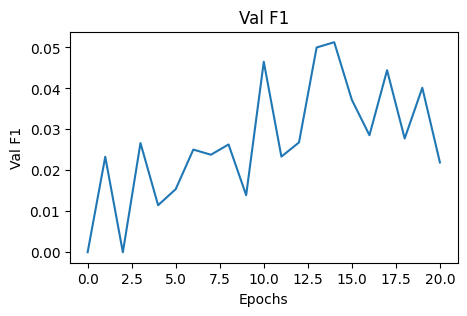

In [ ]:
vl_f1s = torch.stack(val_f1s).cpu().numpy()

plt.figure(figsize=(5, 3))
plt.plot(vl_f1s)
plt.xlabel("Epochs")
plt.ylabel("Val F1")
plt.title("Val F1")
plt.show()

In [ ]:
# Проверяем используется ли gpu, и если да, то используем его
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Загрузка чекпойнта.
model = PneumothoraxModelIGG13.load_from_checkpoint("/content/logs_b/lightning_logs/version_0/checkpoints/epoch=11-step=3204.ckpt", model_class=IVGG13_b)
model.eval()
model.to(device)

PneumothoraxModelIGG13(
  (model): IVGG13_b(
    (conv_blocks): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): LeakyReLU(negative_slope=0.2, inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [ ]:
# Теперь вычислим метрики на всем валидационном датасете
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())

        preds.append(pred)
        labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2135 [00:00<?, ?it/s]

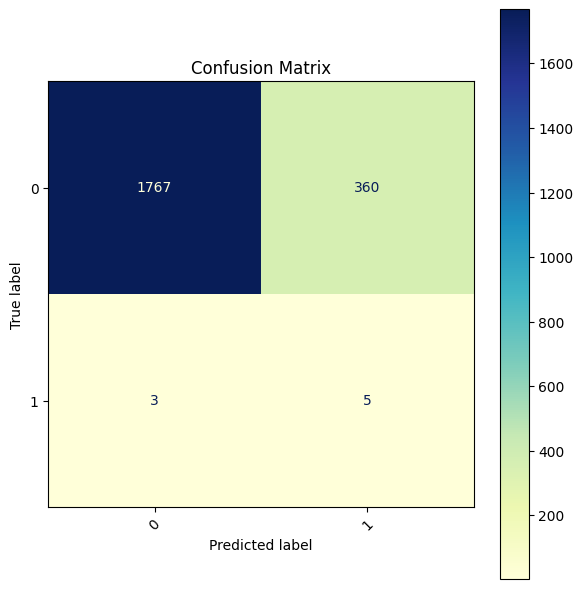

In [ ]:
# Преобразуем тензоры в numpy массивы
y_true = labels.numpy()
prediction = preds.detach().numpy()

# Преобразуем prediction в бинарные метки
prediction_binary = (prediction > 0.5).astype(int)

# Вызываем функцию plot_confusion_matrix
plot_confusion_matrix(y_true=y_true,
                      prediction=prediction_binary,
                      cmap='YlGnBu')

Рассмотрим матрицу ошибок на обучающих данных.

  0%|          | 0/8540 [00:00<?, ?it/s]

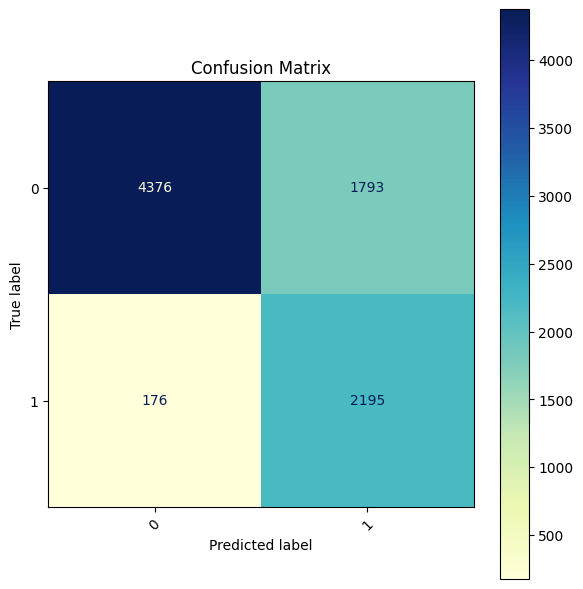

In [ ]:
# Делаем предсказания для тренировочных данных
preds_train = []
labels_train = []

with torch.no_grad():
    for data, label in tqdm(train_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())

        preds_train.append(pred)
        labels_train.append(label)

# Преобразуем тензоры в numpy массивы
y_true_train = torch.tensor(labels_train).int().numpy()
prediction_train = torch.tensor(preds_train).numpy()

# Преобразуем prediction в бинарные метки
prediction_binary_train = (prediction_train > 0.5).astype(int)

# Вызываем функцию plot_confusion_matrix
plot_confusion_matrix(y_true=y_true_train,
                      prediction=prediction_binary_train,
                      cmap='YlGnBu')

In [ ]:
# Вычисляем метрики для вашей модели
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)
f1score = torchmetrics.F1Score(task="binary")(preds, labels)
roc_auc = roc_auc_score(labels, preds)

# Преобразуем тензоры в numpy массивы и берем их значения
acc_value = acc.numpy().item()
precision_value = precision.numpy().item()
recall_value = recall.numpy().item()
f1score_value = f1score.numpy().item()

# Создаем новую строку и добавляем ее в metrics_df
new_row = pd.DataFrame({'Model': ['IVGG13_b'],
                        'Accuracy': [acc_value],
                        'Precision': [precision_value],
                        'Recall': [recall_value],
                        'F1 Score': [f1score_value],
                        'ROC AUC Score': [roc_auc]})

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,IVGG13,0.851991,0.018750,0.750,0.036585,0.818054
1,IVGG13_b,0.829977,0.013699,0.625,0.026810,0.832863


In [ ]:
cm = torchmetrics.ConfusionMatrix(#num_classes=2,
                                  task="binary")(preds, labels)

In [ ]:
tpr = cm[1][1] / (cm[1][1] + cm[1][0])
fpr = cm[0][1] / (cm[0][1] + cm[0][0])

print (f'True Positive Rate (threshold = 0.5): {tpr:.2f}')
print (f'False Positive Rate (threshold = 0.5): {fpr:.2f}')

True Positive Rate (threshold = 0.5): 0.62
False Positive Rate (threshold = 0.5): 0.17


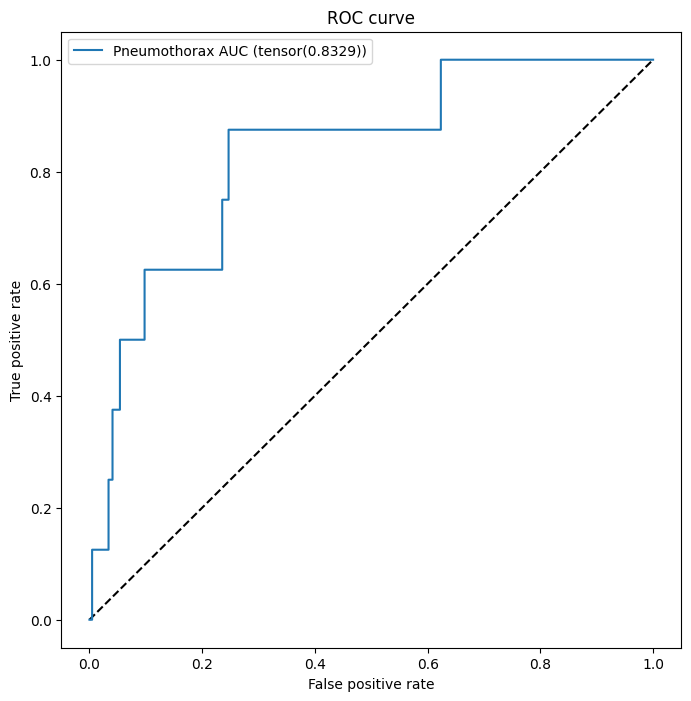

In [ ]:
auroc = AUROC(task='binary')
auc_roc = auroc(preds, labels)
roc_curve = torchmetrics.ROC(task='binary')
fpr_rf, tpr_rf, thresholds = roc_curve(preds,labels)
plt.figure(1, figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = "Pneumothorax AUC (" + str(auc_roc) + ")")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='upper left')

In [ ]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,IVGG13,0.851991,0.018750,0.750,0.036585,0.818054
1,IVGG13_b,0.829977,0.013699,0.625,0.026810,0.832863


**Выводы:**
- опять же достаточно быстро идёт обучение модели по эпохам
- результаты такие же плохие, но roc_auc всё таки чуть лучше
- модель на обучающих данных допускает больше ложноположительных ошибок, чем первая модель IVGG13, но зато получает улучшение в положительном классе true positive

## Модель res_net18 (с занятия)

У нас датасет, который не соответствует тому, который был показан на занятии. Поэтому проверим как работает модель, которую рассматривали на уроке. Перепишем весь код.

In [ ]:
ROOT_PATH = Path("/content/kaggle/input/train/dicom_files")
SAVE_PATH_LESSON = Path("/content/Processed/Lesson/")

In [ ]:
labels = pd.read_csv('/content/kaggle/input/train/train-rle.csv')
labels = labels.drop_duplicates('ImageId')
labels.columns = ['ImageId', 'Target']

# Преобразуем строки в списки чисел
labels['Target'] = labels['Target'].str.split()

# Преобразуем списки в числовые значения
labels['Target'] = labels['Target'].apply(lambda x: [int(i) for i in x])

def transform_target(x):
    if x != [-1]:
        return 1
    else:
        return 0

labels['Target'] = labels['Target'].apply(transform_target)
labels['Target'] = labels.Target.astype('int64')

In [ ]:
n_train = 10675 * 4/5
size = 224

In [ ]:
# Определим две переменные для хранения суммы и суммы квадратов
sums, sums_squared = 0, 0

for c, image_id in enumerate(tqdm(labels.ImageId)):
    dcm_path = glob('/content/kaggle/input/train/dicom_files/' + image_id + '.dcm')[0]

    dcm = pydicom.read_file(str(dcm_path)).pixel_array / 255

    dcm_array = cv2.resize(dcm, (size, size)).astype(np.float16)

    label = labels.Target.iloc[c]
    train_or_val = "train" if c < n_train else "val"

    current_save_path = SAVE_PATH_LESSON/str(train_or_val)/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/image_id, dcm_array)

    # Определим количество пикселей в изображении, т.е. 128*128
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]

    # Используем только тренировочные данные для расчета статистик, это необходимо, чтобы валидационные
    # данные не имели влияния на тренировочные
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

  0%|          | 0/10675 [00:00<?, ?it/s]

In [ ]:
mean = sums / n_train
std = np.sqrt((sums_squared / n_train) - mean**2)
print(f"Среднее: {mean}, Ст. отклонение: {std}")

Среднее: 0.49046931382330444, Ст. отклонение: 0.2471865758997266


In [ ]:
mean = 0.49046931382330444
std = 0.2471865758997266

In [ ]:
!mkdir /content/Processed_lesson/

In [ ]:
train_transforms = transforms.Compose([
                                    # конвертирует numpy array в тензор
                                    transforms.ToTensor(),
                                    # принимает в качестве аргументов наши, уже вычисленные mean and std
                                    transforms.Normalize(mean, std),
                                    # Аугментация данных. Рандомное афинное преобразование изображений.
                                    transforms.RandomAffine(
                                        # поворот на +-5 градусов
                                        degrees=(-5, 5),
                                        # трансляция на максимум 5%
                                        translate=(0, 0.05),
                                        # масштабирование
                                        scale=(0.9, 1.1)),
                                    # обрезает рандомные части изображения и затем выполняет ресайз до требуемого разрешения
                                    # важно, чтобы не обрезались части изображения, содержащие пневмоторакс
                                    # аргумент scale содержит кортеж, определяющий нижнюю и верхнюю границы кадрирования.
                                    transforms.RandomResizedCrop((224, 224), scale=(0.15, 1))

])

# для валидационный выборки нам не требуются все трансформации, поэтому оставляем только конвертацию в тензор и нормализацию
val_transforms = transforms.Compose([
                                    # конвертирует numpy array в тензор
                                    transforms.ToTensor(),
                                    # принимает в качестве аргументов наши, уже вычисленные mean and std
                                    transforms.Normalize(mean, std)
])




In [ ]:
train_dataset = torchvision.datasets.DatasetFolder(
    f'{SAVE_PATH_LESSON}/train',
    loader=load_file,
    extensions="npy",
    transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    f'{SAVE_PATH_LESSON}/val',
    loader=load_file,
    extensions='npy',
    transform=val_transforms)

In [ ]:
batch_size = 32
num_workers = 2

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)

print(f"Всего {len(train_dataset)} тренировочных изображений и {len(val_dataset)} валидационных.")

Всего 8540 тренировочных изображений и 2135 валидационных.


In [ ]:
class PneumothoraxModel(pl.LightningModule):

    def __init__(self, weight=3):

        super().__init__()

        self.model = torchvision.models.resnet18()

        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)
        self.log('Train Loss', loss)
        self.log('Step Train Acc', self.train_acc(torch.sigmoid(pred), label.int()))

        return loss

    def on_train_epoch_end(self):
        self.log("Train Acc", self.train_acc.compute())

    def validation_step(self, batch, batch_idx):
        # Те же шаги, что и в training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0] # TODO что тут происходит?

        loss = self.loss_fn(pred, label)

        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss

    def on_val_epoch_end(self):
        self.log("Val Acc", self.val_acc.compute())

        # Возвращает список оптимизаторов.
    def configure_optimizers(self):
        return [self.optimizer]

In [ ]:
# создаем экземпляр модели
model = PneumothoraxModel()

In [ ]:
# создаем чекпоинт, основанный на валидационной accuracy
# автоматически сохраняет чекпоинты в течение тренинга
checkpoint_callback = ModelCheckpoint(
    monitor='Step Val Acc',
    save_top_k=10,
    mode='max')

In [ ]:
gpus = 1
trainer = pl.Trainer(#gpus=gpus,
                     logger=TensorBoardLogger(save_dir="./logs_lesson"),
                     log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=35` reached.


### Результаты

In [ ]:
# Проверяем используется ли gpu, и если да, то используем его
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Загрузка чекпойнта.
model = PneumothoraxModel.load_from_checkpoint("/content/logs_lesson/lightning_logs/version_0/checkpoints/epoch=22-step=6141.ckpt")
model.eval()
model.to(device)

PneumothoraxModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
# Теперь вычислим метрики на всем валидационном датасете
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())

        preds.append(pred)
        labels.append(label)

# Конвертируем списки в тензор, чтобы использовать torch.metrics
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2135 [00:00<?, ?it/s]

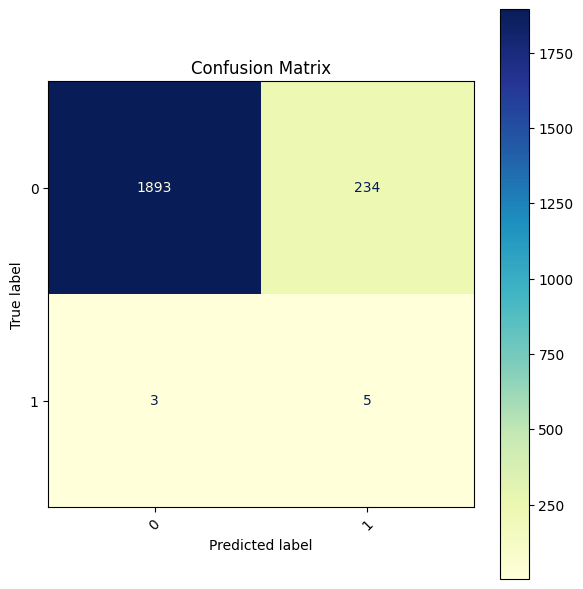

In [ ]:
# Преобразуем тензоры в numpy массивы
y_true = labels.numpy()
prediction = preds.detach().numpy()

# Преобразуем prediction в бинарные метки
prediction_binary = (prediction > 0.5).astype(int)

# Вызываем функцию plot_confusion_matrix
plot_confusion_matrix(y_true=y_true,
                      prediction=prediction_binary,
                      cmap='YlGnBu')

  0%|          | 0/8540 [00:00<?, ?it/s]

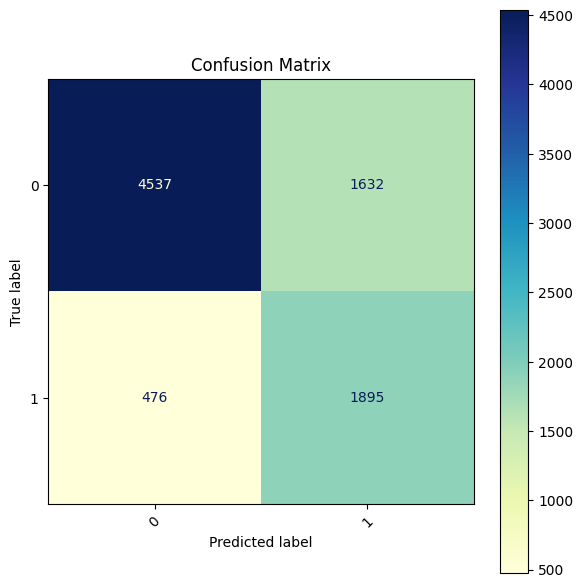

In [ ]:
# Делаем предсказания для тренировочных данных
preds_train = []
labels_train = []

with torch.no_grad():
    for data, label in tqdm(train_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())

        preds_train.append(pred)
        labels_train.append(label)

# Преобразуем тензоры в numpy массивы
y_true_train = torch.tensor(labels_train).int().numpy()
prediction_train = torch.tensor(preds_train).numpy()

# Преобразуем prediction в бинарные метки
prediction_binary_train = (prediction_train > 0.5).astype(int)

# Вызываем функцию plot_confusion_matrix
plot_confusion_matrix(y_true=y_true_train,
                      prediction=prediction_binary_train,
                      cmap='YlGnBu')

In [ ]:
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)
f1score = torchmetrics.F1Score(task="binary")(preds, labels)
cm = torchmetrics.ConfusionMatrix(#num_classes=2,
                                  task="binary")(preds, labels)
# cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.73, task="binary")(preds, labels)

print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1score}")
print(f"Confusion Matrix:\n {cm}")

Accuracy: 0.888992965221405
Precision: 0.02092050202190876
Recall: 0.625
F1 Score: 0.04048582911491394
Confusion Matrix:
 tensor([[1893,  234],
        [   3,    5]])


In [ ]:
tpr = cm[1][1] / (cm[1][1] + cm[1][0])
fpr = cm[0][1] / (cm[0][1] + cm[0][0])

print (f'True Positive Rate (threshold = 0.5): {tpr:.2f}')
print (f'False Positive Rate (threshold = 0.5): {fpr:.2f}')

True Positive Rate (threshold = 0.5): 0.62
False Positive Rate (threshold = 0.5): 0.11


In [ ]:
# Вычисляем метрики для вашей модели
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)
f1score = torchmetrics.F1Score(task="binary")(preds, labels)
roc_auc = roc_auc_score(labels, preds)

# Преобразуем тензоры в numpy массивы и берем их значения
acc_value = acc.numpy().item()
precision_value = precision.numpy().item()
recall_value = recall.numpy().item()
f1score_value = f1score.numpy().item()

# Создаем новую строку и добавляем ее в metrics_df
new_row = pd.DataFrame({'Model': ['Res_Net18'],
                        'Accuracy': [acc_value],
                        'Precision': [precision_value],
                        'Recall': [recall_value],
                        'F1 Score': [f1score_value],
                        'ROC AUC Score': [roc_auc]})

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,IVGG13,0.851991,0.018750,0.750,0.036585,0.818054
1,IVGG13_b,0.829977,0.013699,0.625,0.026810,0.832863
2,Res_Net18,0.888993,0.020921,0.625,0.040486,0.834979


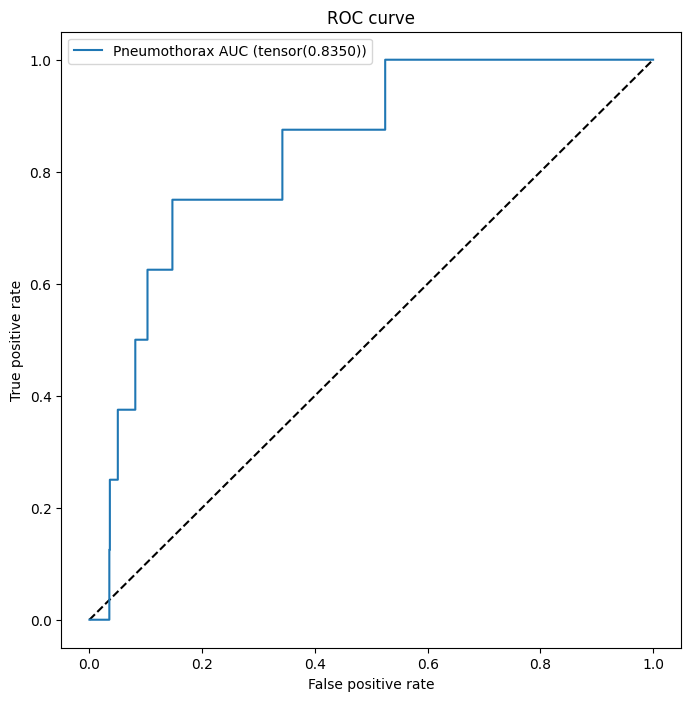

In [ ]:
auroc = AUROC(task='binary')
auc_roc = auroc(preds, labels)
roc_curve = torchmetrics.ROC(task='binary')
fpr_rf, tpr_rf, thresholds = roc_curve(preds,labels)
plt.figure(1, figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = "Pneumothorax AUC (" + str(auc_roc) + ")")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='upper left')

In [ ]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,IVGG13,0.851991,0.018750,0.750,0.036585,0.818054
1,IVGG13_b,0.829977,0.013699,0.625,0.026810,0.832863
2,Res_Net18,0.888993,0.020921,0.625,0.040486,0.834979


**Выводы:**
- видим схожие результаты с IVGG13. Результаты достаточно плохие
- нельзя сказать, что какая-то модель показала результаты сильно лучше другой
- формально res_net18 чуть лучше roc_auc среди всех представленных моделей